In [1]:
# get the training data (e.g. all the data we have previously on the park), 1 num_timesteps initially, each running for 5 steps
# train the prediction model 
# have it predict probs for the most recent timestep 
# take those probabilities and give it to singleplanner and run for 5 steps  
# repeat

from paws import data_generation, multiple_timesteps, create_dataframe, iWare, setup_data, discretization
import numpy as np
import pandas as pd
from SinglePlanner import SinglePlanner
import random

file1 = "GeneratedData/paws_preds.npy"
file2 = "GeneratedData/paws_traps.npy"
file3 = "GeneratedData/paws_prey.npy"
# data_generation(file1, file2, file3) 

M = 25
N = 25

def retrain_model(preds, traps):
    df = create_dataframe(preds, traps)
    features, labels, effort, timestamps = setup_data(df)
    iware = iWare()
    train_x, test_x, train_y, test_y, train_effort, test_effort = iware.train_test_split_by_year(features, labels, effort, timestamps, max(timestamps))
    iware.train_iware(train_x, train_y, train_effort)
    return iware

def milp_traps(M, N, iware): 
    effortx, data = discretization(iware)
    sp = SinglePlanner()
    sol = sp.test(effortx, data)
    traps = np.zeros((M, N))
    for i in range(len(sol)): 
        row = i // M
        col = i % N
        if random.random() <= sol[i]: 
            traps[row][col] = 10 
    return traps

def run(file1, file2, file3):
    # initial data stuff 
    pred_densities, trap_densities, prey_densities = np.load(file1), np.load(file2), np.load(file3)
    df_dict = {"Timestamps": [], "Label": [], "X": [], "Y": [], "Density": [], "Trap Effort": [], "Previous Success": []}
    df = pd.DataFrame(df_dict)

    # how many times we retrain model and call milp_traps 
    for idx in range(2): 
        # start using the milp generated traps 
        iware = retrain_model(pred_densities, trap_densities)
        prey_densities, pred_densities, trap_densities = multiple_timesteps(prey_densities, pred_densities, trap_densities, milp_traps(M, N, iware))
    return prey_densities, pred_densities 

prey, pred = run(file1, file2, file3)



    

train x, y (6250, 3) (6250,)
test x, y  (625, 3) (625,)
trap effort train, test  (6250,) (625,)
percentiles [ 0. 20. 40. 60. 80.]
patrol thresholds [0. 0. 0. 0. 0.]
shape x (6250, 3)
shape y (6250,)
shape train_effort (6250,)
-------------------------------------------
training classifiers with all train data
-------------------------------------------
0
filtered data: (6250, 3). num positive labels 160
classifier 0, threshold 0.0, num x (6250, 3)
  train time: 0.06 seconds, score: 0.97440
-------------------------------------------
threshold 1 same as previous, value 0.0. skipping
threshold 2 same as previous, value 0.0. skipping
threshold 3 same as previous, value 0.0. skipping
threshold 4 same as previous, value 0.0. skipping
Classifier 1 is None; skipping
Classifier 2 is None; skipping
Classifier 3 is None; skipping
Classifier 4 is None; skipping
Classifier 1 is None; skipping
Classifier 2 is None; skipping
Classifier 3 is None; skipping
Classifier 4 is None; skipping
Classifier 1 

/Users/catherinecui/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(



Classifier 2 is None; skipping
Classifier 3 is None; skipping
Classifier 4 is None; skipping
Classifier 1 is None; skipping
Classifier 2 is None; skipping
Classifier 3 is None; skipping
Classifier 4 is None; skipping
Classifier 1 is None; skipping
Classifier 2 is None; skipping
Classifier 3 is None; skipping
Classifier 4 is None; skipping
Classifier 1 is None; skipping
Classifier 2 is None; skipping
Classifier 3 is None; skipping
Classifier 4 is None; skipping
Classifier 1 is None; skipping
Classifier 2 is None; skipping
Classifier 3 is None; skipping
Classifier 4 is None; skipping
Classifier 1 is None; skipping
Classifier 2 is None; skipping
Classifier 3 is None; skipping
Classifier 4 is None; skipping
Classifier 1 is None; skipping
Classifier 2 is None; skipping
Classifier 3 is None; skipping
Classifier 4 is None; skipping
Classifier 1 is None; skipping
Classifier 2 is None; skipping
Classifier 3 is None; skipping
Classifier 4 is None; skipping
Classifier 1 is None; skipping
Classif

/Users/catherinecui/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(



Classifier 2 is None; skipping
Classifier 3 is None; skipping
Classifier 4 is None; skipping
Classifier 1 is None; skipping
Classifier 2 is None; skipping
Classifier 3 is None; skipping
Classifier 4 is None; skipping
Classifier 1 is None; skipping
Classifier 2 is None; skipping
Classifier 3 is None; skipping
Classifier 4 is None; skipping
Classifier 1 is None; skipping
Classifier 2 is None; skipping
Classifier 3 is None; skipping
Classifier 4 is None; skipping
Classifier 1 is None; skipping
Classifier 2 is None; skipping
Classifier 3 is None; skipping
Classifier 4 is None; skipping
Classifier 1 is None; skipping
Classifier 2 is None; skipping
Classifier 3 is None; skipping
Classifier 4 is None; skipping
Classifier 1 is None; skipping
Classifier 2 is None; skipping
Classifier 3 is None; skipping
Classifier 4 is None; skipping
Classifier 1 is None; skipping
Classifier 2 is None; skipping
Classifier 3 is None; skipping
Classifier 4 is None; skipping
Classifier 1 is None; skipping
Classif

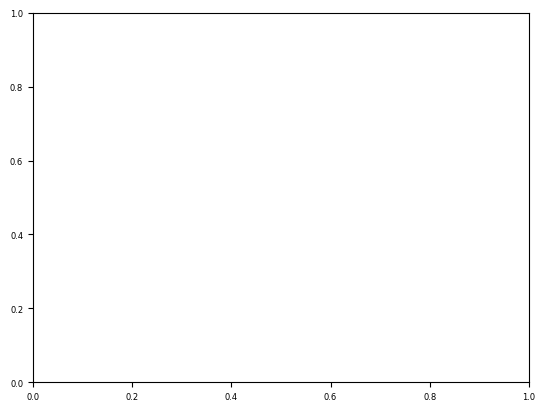

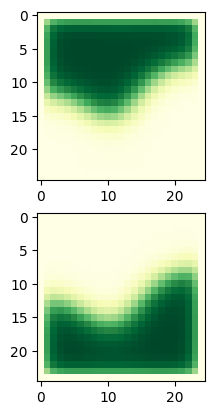

In [2]:
# print("hakkunah", prey.shape, pred.shape)

from ipywidgets import interact, IntSlider 
import matplotlib.pyplot as plt 
import matplotlib

def plot_densities_at_timestep(prey_densities, pred_densities, timestep): 
    min1, max1 = np.amin(pred_densities), np.amax(pred_densities)
    min2, max2 = np.amin(prey_densities), np.amax(prey_densities)
    _min, _max = min(min1, min2), max(max1, max2)

    fig = plt.figure() 
    ax = fig.add_subplot(2, 1, 1)
    ax.imshow(prey_densities[:, :, timestep], cmap=plt.cm.YlGn, vmin=_min, vmax=_max)
    ax2= fig.add_subplot(2, 1, 2)
    ax2.imshow(pred_densities[:, :, timestep], cmap=plt.cm.YlGn, vmin=_min, vmax=_max)

    plt.show()

plot_densities_at_timestep(prey, pred, 0)



In [3]:
from ipywidgets import interact, IntSlider, fixed
import matplotlib.pyplot as plt 

interact(plot_densities_at_timestep, prey_densities=fixed(prey), pred_densities=fixed(pred), timestep=IntSlider(min=0, max=30, step=1, value=0))


interactive(children=(IntSlider(value=0, description='timestep', max=30), Output()), _dom_classes=('widget-int…

<function __main__.plot_densities_at_timestep(prey_densities, pred_densities, timestep)>